In [1]:
import cv2
import datetime
import keras.preprocessing.image
import math
import matplotlib.pyplot
import numpy
import os
import pathlib
import re
import skimage.morphology
import skimage.io
import sklearn
import sklearn.model_selection  
import sklearn.utils
import tensorflow

from albumentations import (
    Compose, HorizontalFlip, ShiftScaleRotate, ElasticTransform,
    RandomBrightness, RandomContrast, RandomGamma
)

In [2]:
path_mask = "mask"
path_images = "images"
image_size = 400

In [ ]:
%%capture
import shutil

with open("a.txt") as arquivo:
    todas_linhas = arquivo.readlines()
    arquivo.close()

dir_original = "images_original"
dir_unet = "images_unet"
for l in todas_linhas:
    l = l.split("->")
    origem = l[0]
    origem = origem.replace("-original.png", "-crop-img-masked-original.png").replace("\n", "")
    nome = l[1].split("/")
    nome = nome[len(nome)-1]
    nome = nome.replace(".jpeg", ".png").replace(".jpg", ".png").replace("\n", "")
    # print(origem, f"images_original/{nome}")
    shutil.copy(origem, f"images_original/{nome}")
    shutil.copy(origem.replace("-original", ""), f"images_unet/{nome}")
    origem = l[0]
    origem = origem.replace("-original.png", "-mask-unet.png").replace("\n", "")
    # nome = nome[len(nome)-1]
    nome = nome.replace(".png", "_mask_unet.png").replace("\n", "")
    print(origem, f"images_unet/{nome}")
    shutil.copy(origem, f"images_unet/{nome}")
    # destino = l[1]    


In [ ]:
%%capture
def get_equivalent():


# lista_final = pathlib.Path("result/final").rglob("[0-9].*-original.png")
# # print(lista_final.)
# for l in lista_final:
    # print(l.resolve())
    for root, subdirs, files in os.walk("result/final"):
        # print(root, subdirs, files)
        # list([filter(re.search(), files)])
        # print(root, list(filter(re.compile(r'^[0-9]*-original.png$').match, files)))
        arq = list(filter(re.compile(r'^[0-9]*-original.png$').match, files))
        if len(arq) > 0:
            for a in arq:
                x.append(os.path.join(root, a))
        #  l = list([os.path.join(root, a) for a in arq])

    # print(x)        
    a = open("a.txt", "w")
    y = pathlib.Path("images").glob("*")
    for i, w in enumerate(y):
        for j, u in enumerate(x):
            # print(f"{i}/{j}")
            f = keras.preprocessing.image.img_to_array(keras.preprocessing.image.load_img(w.resolve()))
            g = keras.preprocessing.image.img_to_array(keras.preprocessing.image.load_img(u))

            comparison = f == g
            if comparison.all():
                print(f"{u}->{w.resolve()}")
                a.write(f"{u}->{w.resolve()}\n")

    a.close()

In [3]:
class AugmentationSequence(tensorflow.keras.utils.Sequence):
    def __init__(self, x_set, y_set, batch_size, augmentations):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.augment = augmentations

    def __len__(self):
        return int(numpy.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]

        aug_x = numpy.zeros(batch_x.shape)
        aug_y = numpy.zeros(batch_y.shape)

        for idx in range(batch_x.shape[0]):
            aug = self.augment(image=batch_x[idx, :, :, :], mask=batch_y[idx, :, :, :])
            aug_x[idx, :, :, :] = aug["image"]
            aug_y[idx, :, :, :] = aug["mask"]

        return aug_x, aug_y

# Data

### Preprocess

In [4]:
def resize_image(image, image_size):
    return cv2.resize(image, (image_size, image_size), interpolation=cv2.INTER_CUBIC)

def get_all_images(dir):
    return [{"filename": file.name, "file": cv2.imread(str(file.resolve()), cv2.IMREAD_GRAYSCALE)}
            for file in pathlib.Path(dir).rglob("*")]

def create_if_not_exists_dir(dir):
    if not os.path.isdir(dir):
        os.makedirs(dir)

def only_resize(list_images, output_dir, image_size):
    create_if_not_exists_dir(output_dir)
    for image in list_images:
        cv2.imwrite(os.path.join(output_dir, image["filename"]), resize_image(image["file"], image_size))

def resize_all():
    for data in [{"path": "new/images", "type": "images"}, {"path": "new/mask", "type": "mask"}]:
            only_resize(get_all_images(data["path"]), data["type"], 400)


In [5]:
def load_mask(filename):
    return numpy.float32(skimage.io.imread(filename) / 255)

def load_all_masks(path):
    return [load_mask(filename) for filename in sorted(pathlib.Path(path).rglob("*"))]

def load_image(filename):
    return skimage.img_as_float32(skimage.io.imread(filename))

def load_all_images(path):
    return [load_image(filename) for filename in sorted(pathlib.Path(path).rglob("*"))]

def width_height_are_equal_image_size(image, image_size):
    return image.shape[0] == image_size and image.shape[1] == image_size

def validate_data(path, image_size):
    return all(not width_height_are_equal_image_size(skimage.io.imread(filename), image_size) for filename in sorted(pathlib.Path(path).rglob("*")))

# GPU

In [6]:
def set_avx_avx2():
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' # INFO messages are not printed

def set_gpu():
    gpus = tensorflow.config.experimental.list_physical_devices("GPU")
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                print(f"GPU: {gpu.name}")
                tensorflow.config.experimental.set_memory_growth(gpu, True)
        except RuntimeError as e:
            print(e)

# Model

In [7]:
def unet_model(keras=None, img_size=None):

    input_img = tensorflow.keras.layers.Input((img_size, img_size, 1), name = "img")

    # Contract #1
    c1 = tensorflow.keras.layers.Conv2D(16, (3, 3), kernel_initializer = "he_uniform", padding = "same")(input_img)
    c1 = tensorflow.keras.layers.BatchNormalization()(c1)
    c1 = tensorflow.keras.layers.Activation("relu")(c1)
    c1 = tensorflow.keras.layers.Dropout(0.1)(c1)
    c1 = tensorflow.keras.layers.Conv2D(16, (3, 3), kernel_initializer = "he_uniform", padding = "same")(c1)
    c1 = tensorflow.keras.layers.BatchNormalization()(c1)
    c1 = tensorflow.keras.layers.Activation("relu")(c1)
    p1 = tensorflow.keras.layers.MaxPooling2D((2, 2))(c1)

    # Contract #2
    c2 = tensorflow.keras.layers.Conv2D(32, (3, 3), kernel_initializer = "he_uniform", padding = "same")(p1)
    c2 = tensorflow.keras.layers.BatchNormalization()(c2)
    c2 = tensorflow.keras.layers.Activation("relu")(c2)
    c2 = tensorflow.keras.layers.Dropout(0.2)(c2)
    c2 = tensorflow.keras.layers.Conv2D(32, (3, 3), kernel_initializer = "he_uniform", padding = "same")(c2)
    c2 = tensorflow.keras.layers.BatchNormalization()(c2)
    c2 = tensorflow.keras.layers.Activation("relu")(c2)
    p2 = tensorflow.keras.layers.MaxPooling2D((2, 2))(c2)

    # Contract #3
    c3 = tensorflow.keras.layers.Conv2D(64, (3, 3), kernel_initializer = "he_uniform", padding = "same")(p2)
    c3 = tensorflow.keras.layers.BatchNormalization()(c3)
    c3 = tensorflow.keras.layers.Activation("relu")(c3)
    c3 = tensorflow.keras.layers.Dropout(0.3)(c3)
    c3 = tensorflow.keras.layers.Conv2D(64, (3, 3), kernel_initializer = "he_uniform", padding = "same")(c3)
    c3 = tensorflow.keras.layers.BatchNormalization()(c3)
    c3 = tensorflow.keras.layers.Activation("relu")(c3)
    p3 = tensorflow.keras.layers.MaxPooling2D((2, 2))(c3)

    # Contract #4
    c4 = tensorflow.keras.layers.Conv2D(128, (3, 3), kernel_initializer = "he_uniform", padding = "same")(p3)
    c4 = tensorflow.keras.layers.BatchNormalization()(c4)
    c4 = tensorflow.keras.layers.Activation("relu")(c4)
    c4 = tensorflow.keras.layers.Dropout(0.4)(c4)
    c4 = tensorflow.keras.layers.Conv2D(128, (3, 3), kernel_initializer = "he_uniform", padding = "same")(c4)
    c4 = tensorflow.keras.layers.BatchNormalization()(c4)
    c4 = tensorflow.keras.layers.Activation("relu")(c4)
    p4 = tensorflow.keras.layers.MaxPooling2D((2, 2))(c4)

    # Middle
    c5 = tensorflow.keras.layers.Conv2D(256, (3, 3), kernel_initializer = "he_uniform", padding = "same")(p4)
    c5 = tensorflow.keras.layers.BatchNormalization()(c5)
    c5 = tensorflow.keras.layers.Activation("relu")(c5)
    c5 = tensorflow.keras.layers.Dropout(0.5)(c5)
    c5 = tensorflow.keras.layers.Conv2D(256, (3, 3), kernel_initializer = "he_uniform", padding = "same")(c5)
    c5 = tensorflow.keras.layers.BatchNormalization()(c5)
    c5 = tensorflow.keras.layers.Activation("relu")(c5)

    # Expand (upscale) #1
    u6 = tensorflow.keras.layers.Conv2DTranspose(128, (3, 3), strides = (2, 2), padding = "same")(c5)
    u6 = tensorflow.keras.layers.concatenate([u6, c4])
    c6 = tensorflow.keras.layers.Conv2D(128, (3, 3), kernel_initializer = "he_uniform", padding = "same")(u6)
    c6 = tensorflow.keras.layers.BatchNormalization()(c6)
    c6 = tensorflow.keras.layers.Activation("relu")(c6)
    c6 = tensorflow.keras.layers.Dropout(0.5)(c6)
    c6 = tensorflow.keras.layers.Conv2D(128, (3, 3), kernel_initializer = "he_uniform", padding = "same")(c6)
    c6 = tensorflow.keras.layers.BatchNormalization()(c6)
    c6 = tensorflow.keras.layers.Activation("relu")(c6)

    # Expand (upscale) #2
    u7 = tensorflow.keras.layers.Conv2DTranspose(64, (3, 3), strides = (2, 2), padding = "same")(c6)
    u7 = tensorflow.keras.layers.concatenate([u7, c3])
    c7 = tensorflow.keras.layers.Conv2D(64, (3, 3), kernel_initializer = "he_uniform", padding = "same")(u7)
    c7 = tensorflow.keras.layers.BatchNormalization()(c7)
    c7 = tensorflow.keras.layers.Activation("relu")(c7)
    c7 = tensorflow.keras.layers.Dropout(0.5)(c7)
    c7 = tensorflow.keras.layers.Conv2D(64, (3, 3), kernel_initializer = "he_uniform", padding = "same")(c7)
    c7 = tensorflow.keras.layers.BatchNormalization()(c7)
    c7 = tensorflow.keras.layers.Activation("relu")(c7)

    # Expand (upscale) #3
    u8 = tensorflow.keras.layers.Conv2DTranspose(32, (3, 3), strides = (2, 2), padding = "same")(c7)
    u8 = tensorflow.keras.layers.concatenate([u8, c2])
    c8 = tensorflow.keras.layers.Conv2D(32, (3, 3), kernel_initializer = "he_uniform", padding = "same")(u8)
    c8 = tensorflow.keras.layers.BatchNormalization()(c8)
    c8 = tensorflow.keras.layers.Activation("relu")(c8)
    c8 = tensorflow.keras.layers.Dropout(0.5)(c8)
    c8 = tensorflow.keras.layers.Conv2D(32, (3, 3), kernel_initializer = "he_uniform", padding = "same")(c8)
    c8 = tensorflow.keras.layers.BatchNormalization()(c8)
    c8 = tensorflow.keras.layers.Activation("relu")(c8)

    # Expand (upscale) #4
    u9 = tensorflow.keras.layers.Conv2DTranspose(16, (3, 3), strides = (2, 2), padding = "same")(c8)
    u9 = tensorflow.keras.layers.concatenate([u9, c1])
    c9 = tensorflow.keras.layers.Conv2D(16, (3, 3), kernel_initializer = "he_uniform", padding = "same")(u9)
    c9 = tensorflow.keras.layers.BatchNormalization()(c9)
    c9 = tensorflow.keras.layers.Activation("relu")(c9)
    c9 = tensorflow.keras.layers.Dropout(0.5)(c9)
    c9 = tensorflow.keras.layers.Conv2D(16, (3, 3), kernel_initializer = "he_uniform", padding = "same")(c9)
    c9 = tensorflow.keras.layers.BatchNormalization()(c9)
    c9 = tensorflow.keras.layers.Activation("relu")(c9)

    output = tensorflow.keras.layers.Conv2D(1, (1, 1), activation = "sigmoid")(c9)
    model = tensorflow.keras.Model(inputs = [input_img], outputs = [output])
    return model

In [8]:
def jaccard_distance_loss(y_true, y_pred, smooth = 100):
    intersection = tensorflow.keras.backend.sum(tensorflow.keras.backend.abs(y_true * y_pred), axis = -1)
    union = tensorflow.keras.backend.sum(tensorflow.keras.backend.abs(y_true) + tensorflow.keras.backend.abs(y_pred), axis = -1)
    jac = (intersection + smooth) / (union - intersection + smooth)
    loss = (1 - jac) * smooth
    return loss


def dice_coef(y_true, y_pred, smooth = 1):
    intersection = tensorflow.keras.backend.sum(tensorflow.keras.backend.abs(y_true * y_pred), axis = -1)
    union = tensorflow.keras.backend.sum(tensorflow.keras.backend.abs(y_true), -1) + tensorflow.keras.backend.sum(tensorflow.keras.backend.abs(y_pred), -1)
    return (2. * intersection + smooth) / (union + smooth)

# Image

In [9]:
def crop_image(img, mask):
    crop_mask = mask > 0
    m, n = mask.shape
    crop_mask0, crop_mask1 = crop_mask.any(0), crop_mask.any(1)
    col_start, col_end = crop_mask0.argmax(), n - crop_mask0[::-1].argmax()
    row_start, row_end = crop_mask1.argmax(), m - crop_mask1[::-1].argmax()
    return img[row_start:row_end, col_start:col_end], mask[row_start:row_end, col_start:col_end]

def process_pred_mask(pred_mask):
    open_pred_mask = skimage.morphology.erosion(pred_mask, skimage.morphology.square(5))
    open_pred_mask = skimage.morphology.dilation(open_pred_mask, skimage.morphology.square(5))
    return skimage.morphology.dilation(open_pred_mask, skimage.morphology.square(5))

def save_image_mask_predmask(filename, image, mask, pred_mask, post_pred_mask, image_original_mask, image_pred_mask):
    figure = matplotlib.pyplot.figure(figsize=(15, 10))
    figure.add_subplot(2, 3, 1).set_title("Original image", fontdict = {"fontsize":18})
    matplotlib.pyplot.imshow(skimage.img_as_ubyte(image), cmap = "gray")
    figure.add_subplot(2, 3, 2).set_title("Original mask", fontdict = {"fontsize":18})
    matplotlib.pyplot.imshow(skimage.img_as_ubyte(mask), cmap = "gray")
    figure.add_subplot(2, 3, 3).set_title("Predicted mask", fontdict = {"fontsize":18})
    matplotlib.pyplot.imshow(pred_mask, cmap = "gray")
    figure.add_subplot(2, 3, 4).set_title("Preprocessed mask", fontdict = {"fontsize":18})
    matplotlib.pyplot.imshow(post_pred_mask, cmap = "gray")
    figure.add_subplot(2, 3, 5).set_title("Image original mask", fontdict = {"fontsize":18})
    matplotlib.pyplot.imshow(image_original_mask, cmap = "gray")
    figure.add_subplot(2, 3, 6).set_title("Image pred mask", fontdict = {"fontsize":18})
    matplotlib.pyplot.imshow(image_pred_mask, cmap = "gray")
    figure.savefig(filename)
  

def save_all_images(X, Y, data_type, model, out_folder):
    for idx in range(0, X.shape[0]):
        test_img = X[idx,:,:,:].reshape((1, image_size, image_size, 1))
        test_mask = Y[idx,:,:,:].reshape((1, image_size, image_size, 1))
        pred_mask = model.predict(test_img)[0,:,:,0]
        image_pred_mask = pred_mask
        pred_mask = numpy.uint8(pred_mask > 0.5)

        open_pred_mask = skimage.morphology.erosion(pred_mask, skimage.morphology.square(5))
        open_pred_mask = skimage.morphology.dilation(open_pred_mask, skimage.morphology.square(5))
        post_pred_mask = skimage.morphology.dilation(open_pred_mask, skimage.morphology.square(5))
        image_out_folder = os.path.join(out_folder, data_type, f"{idx}")

        # crop_img, crop_mask = crop_image(test_img[0,:,:,0], post_pred_mask) # keep
        crop_img_masked = test_img[0,:,:,0] * pred_mask
        mask_original = numpy.uint8(test_mask[0,:,:,0] > 0.5)
        crop_img_masked_original = test_img[0,:,:,0] * mask_original
        crop_img_masked[crop_img_masked == 0] = 1
        crop_img_masked_original[crop_img_masked_original == 0] = 1

        if not os.path.exists(image_out_folder):
            os.makedirs(image_out_folder)

        skimage.io.imsave(os.path.join(image_out_folder, f"{idx}-original.png"), skimage.img_as_ubyte(test_img[0,:,:,0]))    
        skimage.io.imsave(os.path.join(image_out_folder, f"{idx}-mask-original.png"), skimage.img_as_ubyte(test_mask[0,:,:,0]))    
        skimage.io.imsave(os.path.join(image_out_folder, f"{idx}-mask-unet.png"), skimage.img_as_ubyte(image_pred_mask))    
        # skimage.io.imsave(os.path.join(image_out_folder, f"{i}-post-pred-mask.png"), post_pred_mask * 255)    
        # skimage.io.imsave(os.path.join(image_out_folder, f"{i}-crop-img.png"), skimage.img_as_ubyte(crop_img))
        # skimage.io.imsave(os.path.join(image_out_folder, f"{i}-crop-mask.png"), crop_mask * 255)    
        skimage.io.imsave(os.path.join(image_out_folder, f"{idx}-crop-img-masked.png"), skimage.img_as_ubyte(crop_img_masked))
        skimage.io.imsave(os.path.join(image_out_folder, f"{idx}-crop-img-masked-original.png"), skimage.img_as_ubyte(crop_img_masked_original))    
        

        save_image_mask_predmask(os.path.join(image_out_folder, f"{idx}.png"), test_img[0,:,:,0], test_mask[0,:,:,0], pred_mask, post_pred_mask, crop_img_masked_original, crop_img_masked)


# Load data

In [10]:
if validate_data(path_mask, image_size) and validate_data(path_images, image_size):
    raise SystemExit("err in input file")

images = load_all_images(path_images)
masks = load_all_masks(path_mask)

0 Counter({'piper': 75, 'pothomorphe': 75, 'ottonia': 75, 'peperomia': 75, 'manekia': 75})
X_train.shape: (270, 400, 400, 1)
Y_train.shape: (270, 400, 400, 1)
X_val.shape: (30, 400, 400, 1)
Y_val.shape: (30, 400, 400, 1)
Y_test.shape: (75, 400, 400, 1)
X_test.shape: (75, 400, 400, 1)


/home/xandao/miniconda3/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:1613: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/home/xandao/miniconda3/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:1639: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
2022-07-06 17:49:04.710099: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/

2022-07-06 17:49:04.778089: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-06 17:49:04.778349: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-06 17:49:04.779330: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-06 17:49:04.780662: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

Epoch 1/10


2022-07-06 17:49:06.906256: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_2316"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\020FlatMapDataset:1"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1


17/17 [==============================] - ETA: 0s - loss: 0.2054 - dice_coef: 0.8839

2022-07-06 17:49:32.650398: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_9844"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\021FlatMapDataset:26"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUC


Epoch 1: val_loss improved from inf to 0.78610, saving model to model/batch16+lr0_05+epoch10+steps17+cv0+unet.h5
17/17 [==============================] - 28s 1s/step - loss: 0.2054 - dice_coef: 0.8839 - val_loss: 0.7861 - val_dice_coef: 0.6042 - lr: 0.0500
Epoch 2/10
17/17 [==============================] - ETA: 0s - loss: 0.1057 - dice_coef: 0.9449
Epoch 2: val_loss did not improve from 0.78610
17/17 [==============================] - 23s 1s/step - loss: 0.1057 - dice_coef: 0.9449 - val_loss: 0.7861 - val_dice_coef: 0.6042 - lr: 0.0500
Epoch 3/10
17/17 [==============================] - ETA: 0s - loss: 0.1025 - dice_coef: 0.9465
Epoch 3: val_loss improved from 0.78610 to 0.78562, saving model to model/batch16+lr0_05+epoch10+steps17+cv0+unet.h5
17/17 [==============================] - 23s 1s/step - loss: 0.1025 - dice_coef: 0.9465 - val_loss: 0.7856 - val_dice_coef: 0.6044 - lr: 0.0500
Epoch 4/10
17/17 [==============================] - ETA: 0s - loss: 0.1051 - dice_coef: 0.9450
Epoch

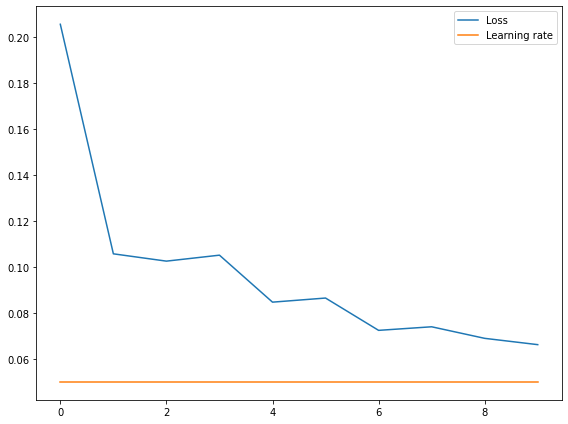

2022-07-06 17:53:00.856988: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_17645"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022FlatMapDataset:185"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PROD

folder result/06-07-2022-17-49-01/0/result-06-07-2022-17-49-01 created
1 Counter({'piper': 75, 'pothomorphe': 75, 'ottonia': 75, 'peperomia': 75, 'manekia': 75})
X_train.shape: (270, 400, 400, 1)
Y_train.shape: (270, 400, 400, 1)
X_val.shape: (30, 400, 400, 1)
Y_val.shape: (30, 400, 400, 1)
Y_test.shape: (75, 400, 400, 1)
X_test.shape: (75, 400, 400, 1)
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Epoch 1/10


2022-07-06 17:56:01.294896: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_73196"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\023FlatMapDataset:9446"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          size:

17/17 [==============================] - ETA: 0s - loss: 0.2369 - dice_coef: 0.8686

2022-07-06 17:56:27.147304: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_80722"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\023FlatMapDataset:9471"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRO


Epoch 1: val_loss improved from inf to 0.19462, saving model to model/batch16+lr0_05+epoch10+steps17+cv1+unet.h5
17/17 [==============================] - 27s 1s/step - loss: 0.2369 - dice_coef: 0.8686 - val_loss: 0.1946 - val_dice_coef: 0.8994 - lr: 0.0500
Epoch 2/10
17/17 [==============================] - ETA: 0s - loss: 0.1443 - dice_coef: 0.9260
Epoch 2: val_loss did not improve from 0.19462
17/17 [==============================] - 23s 1s/step - loss: 0.1443 - dice_coef: 0.9260 - val_loss: 0.1958 - val_dice_coef: 0.8988 - lr: 0.0500
Epoch 3/10
17/17 [==============================] - ETA: 0s - loss: 0.1043 - dice_coef: 0.9453
Epoch 3: val_loss did not improve from 0.19462
17/17 [==============================] - 22s 1s/step - loss: 0.1043 - dice_coef: 0.9453 - val_loss: 0.1946 - val_dice_coef: 0.8994 - lr: 0.0500
Epoch 4/10
17/17 [==============================] - ETA: 0s - loss: 0.1048 - dice_coef: 0.9451
Epoch 4: val_loss improved from 0.19462 to 0.19425, saving model to model/b

In [11]:
from collections import Counter


current_datetime = datetime.datetime.now().strftime('%d-%m-%Y-%H-%M-%S')
count_cv = 2

def get_genus(filename):
    list_genus = ["manekia", "ottonia", "peperomia", "piper", "pothomorphe"]
    return next((g for g in list_genus if g in filename), ValueError("a"))

def get_path_mask(filename):
    filename = re.sub(r".[a-z]*$", "", filename)
    list_mask = list([str(file.resolve()) for file in pathlib.Path(path_mask).rglob("*")])
    return next((m for m in list_mask if filename in m), ValueError("a"))

def a(index_cv, X_train, Y_train, X_val, Y_val, X_test, Y_test, sum_iou_train, sum_dice_train, sum_iou_val, sum_dice_val, sum_iou_test, sum_dice_test):
    images_test_ids = []

    nimages = X_test.shape[0]
    for idx in range(nimages):
        test_image = X_test[idx,:,:,0]
        if any(numpy.array_equal(test_image, x) for x in images):
            images_test_ids.append(idx)

    learning_rate = 0.05
    batch_size = 16
    epochs = 10
    steps_per_epoch = math.ceil(X_train.shape[0] / batch_size)         

    augment = Compose([
        HorizontalFlip(),
        ShiftScaleRotate(rotate_limit=45, border_mode=cv2.BORDER_CONSTANT),
        ElasticTransform(border_mode=cv2.BORDER_CONSTANT),
        RandomBrightness(),
        RandomContrast(),
        RandomGamma()
    ])

    train_generator = AugmentationSequence(X_train, Y_train, batch_size, augment)   

    unet_filename = os.path.join("model", f"batch{batch_size}+lr{str(learning_rate).replace('.', '_')}+epoch{epochs}+steps{steps_per_epoch}+cv{index_cv}+unet.h5")

    reduce_learning_rate = tensorflow.keras.callbacks.ReduceLROnPlateau(monitor = "loss", factor = 0.5, patience = 3, verbose = 1)

    checkpointer = tensorflow.keras.callbacks.ModelCheckpoint(unet_filename, verbose = 1, save_best_only = True)

    strategy = tensorflow.distribute.MirroredStrategy()
    model = None
    fit = None
    if os.path.exists(unet_filename):
        model = tensorflow.keras.models.load_model(unet_filename, custom_objects = {"jaccard_distance_loss": jaccard_distance_loss,"dice_coef": dice_coef})
        print("aqui")
    else:
        with strategy.scope():
            model = unet_model()
            adam_opt = tensorflow.keras.optimizers.Adam(learning_rate = learning_rate)
            model.compile(optimizer = adam_opt, loss = jaccard_distance_loss, metrics = [dice_coef])
        
        fit = model.fit(train_generator, 
            steps_per_epoch = steps_per_epoch, 
            epochs = epochs,
            validation_data = (X_val, Y_val),
            callbacks = [checkpointer, reduce_learning_rate]
        )

        if not os.path.exists("result"):
            os.makedirs("result")

        out_folder = os.path.join("result", current_datetime, str(index_cv))

        if not os.path.exists(out_folder):
            os.makedirs(out_folder)

        name_outfile = f"result-{current_datetime}"            
        path_outfile = os.path.join(out_folder, name_outfile)


        print(fit.history.keys())
        # dict_keys(['loss', 'dice_coef', 'val_loss', 'val_dice_coef', 'lr'])

        fig, ax = matplotlib.pyplot.subplots(1, figsize=(8,6))

        ax.plot(numpy.arange(0, epochs), fit.history["loss"], 
                label="Loss")
        ax.plot(numpy.arange(0, epochs), fit.history["lr"], 
                label="Learning rate")
        ax.legend()

        matplotlib.pyplot.tight_layout()
        matplotlib.pyplot.show()
        fig.savefig(f"{path_outfile}-lossgraph.png")



    iou_train, dice_train = model.evaluate(X_train, Y_train, verbose = False)
    iou_val, dice_val = model.evaluate(X_val, Y_val, verbose = False)
    iou_test, dice_test = model.evaluate(X_test, Y_test, verbose = False)

    sum_iou_train += iou_train
    sum_dice_train += dice_train
    sum_iou_val += iou_val
    sum_dice_val += dice_val
    sum_iou_test += iou_test
    sum_dice_test += dice_test

    if not os.path.exists("result"):
        os.makedirs("result")

    out_folder = os.path.join("result", current_datetime, str(index_cv))

    if not os.path.exists(out_folder):
        os.makedirs(out_folder)

    name_outfile = f"result-{current_datetime}"
    path_outfile = os.path.join(out_folder, name_outfile)
    # matplotlib.pyplot.savefig(f"{path_outfile}-lossgraph.png")

    fig = matplotlib.pyplot.figure(constrained_layout=True, figsize=(60, 20))
    fig.suptitle(f"Result {datetime.datetime.now().strftime('%d/%m/%Y %H:%M:%S')}", fontsize=36, color="r")

    subfigs = fig.subfigures(nrows=3, ncols=1)
    titles = ["Original", "Mask original", "Mask u-net"]
    for i, subfig in enumerate(subfigs):
        subfig.suptitle(titles[i], fontsize=28, color="r")

        axs = subfig.subplots(nrows=1, ncols=8)
        for j, ax in enumerate(axs):
            if i == 0:
                test_img = X_test[j,:,:,:].reshape((1, image_size, image_size, 1))
                ax.imshow(skimage.img_as_ubyte(test_img[0,:,:,0]), cmap = "gray")
            elif i == 1:
                test_mask = Y_test[j,:,:,:].reshape((1, image_size, image_size, 1))
                ax.imshow(skimage.img_as_ubyte(test_mask[0,:,:,0]), cmap = "gray")
            elif i == 2:
                test_img = X_test[j,:,:,:].reshape((1, image_size, image_size, 1))
                pred_mask = model.predict(test_img)[0,:,:,0]
                pred_mask = numpy.uint8(pred_mask > 0.5)
                ax.imshow(pred_mask, cmap = "gray")
    fig.savefig(f"{path_outfile}.png")

    try:
        with open(f"{path_outfile}.txt", "w") as outfile:
            outfile.write(f"unet filename={unet_filename}\n")    
            outfile.write(f"index cv={index_cv}\n")    
            outfile.write(f"X: {X.shape}, X_train: {X_train.shape}, X_val: {X_val.shape}, X_test: {X_test.shape}\n")
            outfile.write(f"learning_rate={learning_rate}, batch_size={batch_size}\n")    
            outfile.write(f"epochs={epochs}, steps={steps_per_epoch}\n")    
            outfile.write(f"============================================\n")    
            outfile.write(f"Jaccard distance (IoU) train: {iou_train}\n")
            outfile.write(f"Dice coeffient train: {dice_train}\n")
            outfile.write(f"Jaccard distance (IoU) validation: {iou_val}\n")
            outfile.write(f"Dice coeffient validation: {dice_val}\n")
            outfile.write(f"Jaccard distance (IoU) test: {iou_test}\n")
            outfile.write(f"Dice coeffient test: {dice_test}\n")
            outfile.close()
    except:
        raise SystemError(f"fail in create outfile {path_outfile}")     

    save_all_images(X_train, Y_train, "train", model, out_folder) 
    save_all_images(X_test, Y_test, "test", model, out_folder) 
    save_all_images(X_val, Y_val, "val", model, out_folder)
    print(f"folder {path_outfile} created")     


list_images = list([{"path_image": str(file.resolve()), "path_mask": get_path_mask(file.name), "label": get_genus(str(file.name))} for file in pathlib.Path(path_images).rglob("*")])   
indices = sklearn.model_selection.StratifiedShuffleSplit(n_splits=count_cv, test_size=0.2, random_state=1234)

sum_iou_train = 0
sum_dice_train = 0
sum_iou_val = 0
sum_dice_val = 0
sum_iou_test = 0
sum_dice_test = 0


X = numpy.array([{"path_image": file["path_image"], "path_mask": file["path_mask"]} for file in list_images])
Y = numpy.array([file["label"] for file in list_images])
for i, (train_index, test_index) in enumerate(indices.split(X, Y)):
    print(i, Counter(Y))
    X_train = numpy.array([load_image(X[i]["path_image"]) for i in train_index])
    X_train = X_train.reshape(X_train.shape[0], image_size, image_size, 1)
    Y_train = numpy.array([load_mask(X[i]["path_mask"]) for i in train_index])
    Y_train = Y_train.reshape(Y_train.shape[0], image_size, image_size, 1)

    X_test = numpy.array([load_image(X[i]["path_image"]) for i in test_index])
    X_test = X_test.reshape(X_test.shape[0], image_size, image_size, 1)
    Y_test = numpy.array([load_mask(X[i]["path_mask"]) for i in test_index])
    Y_test = Y_test.reshape(Y_test.shape[0], image_size, image_size, 1)

    X_train, X_val, Y_train, Y_val = sklearn.model_selection.train_test_split(X_train, Y_train, 
    test_size=0.1, random_state=1234)

    print(f"X_train.shape: {X_train.shape}")
    print(f"Y_train.shape: {Y_train.shape}")
    print(f"X_val.shape: {X_val.shape}")
    print(f"Y_val.shape: {Y_val.shape}")
    print(f"Y_test.shape: {Y_test.shape}")
    print(f"X_test.shape: {X_test.shape}")
    
    a(i, X_train, Y_train, X_val, Y_val, X_test, Y_test, sum_iou_train, sum_dice_train, sum_iou_val, sum_dice_val, sum_iou_test, sum_dice_test)

# aqui eh a media
try:
    with open(f"{os.path.join('result', current_datetime)}.txt", "w") as outfile:
        outfile.write(f"Mean Jaccard distance (IoU) train: {sum_iou_train/count_cv}\n")
        outfile.write(f"Mean Dice coeffient train: {sum_dice_train/count_cv}\n")
        outfile.write(f"Mean Jaccard distance (IoU) validation: {sum_iou_val/count_cv}\n")
        outfile.write(f"Mean Dice coeffient validation: {sum_dice_val/count_cv}\n")
        outfile.write(f"Mean Jaccard distance (IoU) test: {sum_iou_test/count_cv}\n")
        outfile.write(f"Mean Dice coeffient test: {sum_dice_test/count_cv}\n")
        outfile.close()
except:
    raise SystemError(f"fail in create outfile {current_datetime}")    


In [ ]:
% capture
X = numpy.array(images).reshape(len(images), image_size, image_size, 1)
Y = numpy.array(masks).reshape(len(masks), image_size, image_size, 1)
X, Y = sklearn.utils.shuffle(X, Y, random_state=1234)

X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X, Y, test_size=0.05, random_state=1234)
X_train, X_val, Y_train, Y_val = sklearn.model_selection.train_test_split(X_train, Y_train, test_size=0.05, random_state=1234)

print(f"X_train: {X_train.shape}")
print(f"X_val: {X_val.shape}")
print(f"X_test: {X_test.shape}")
print(f"X: {X.shape}")

In [ ]:
%%capture
print(f"images[50].shape: {images[50].shape}")
print(f"masks[50].shape: {masks[50].shape}")
f = matplotlib.pyplot.figure()
f.add_subplot(3, 2, 1)
matplotlib.pyplot.imshow(images[50], cmap = "gray")
f.add_subplot(3, 2, 2)
matplotlib.pyplot.imshow(masks[50], cmap = "gray")

In [ ]:
images_test_ids = []

nimages = X_test.shape[0]
for idx in range(nimages):
	test_image = X_test[idx,:,:,0]
	if any(numpy.array_equal(test_image, x) for x in images):
		images_test_ids.append(idx)


# Model configuration

In [ ]:
learning_rate = 0.001
batch_size = 16
epochs = 100
steps_per_epoch = math.ceil(X_train.shape[0] / batch_size)

# Data augmentation

In [ ]:
augment = Compose([
        HorizontalFlip(),
        ShiftScaleRotate(rotate_limit=45, border_mode=cv2.BORDER_CONSTANT),
        ElasticTransform(border_mode=cv2.BORDER_CONSTANT),
        RandomBrightness(),
        RandomContrast(),
        RandomGamma()
    ])

train_generator = AugmentationSequence(X_train, Y_train, batch_size, augment)

In [ ]:
%%capture
X_aug, Y_aug = train_generator.__getitem__(20)
f = matplotlib.pyplot.figure(figsize=(10, 10))
f.add_subplot(4, 2, 1)
matplotlib.pyplot.imshow(X_aug[0,:,:,0], cmap = "gray")
f.add_subplot(4, 2, 2)
matplotlib.pyplot.imshow(Y_aug[0,:,:,0], cmap = "gray")

f.add_subplot(4, 2, 3)
matplotlib.pyplot.imshow(X_aug[1,:,:,0], cmap = "gray")
f.add_subplot(4, 2, 4)
matplotlib.pyplot.imshow(Y_aug[1,:,:,0], cmap = "gray")

# Model

In [ ]:
unet_filename = os.path.join("model", f"batch{batch_size}+lr{str(learning_rate).replace('.', '_')}+epoch{epochs}+steps{steps_per_epoch}+unet.h5")
# unet_filename = os.path.join("model", "batch4+lr0_05+epoch200+steps85+unet.h5")

reduce_learning_rate = tensorflow.keras.callbacks.ReduceLROnPlateau(monitor = "loss", factor = 0.5, patience = 3, verbose = 1)

checkpointer = tensorflow.keras.callbacks.ModelCheckpoint(unet_filename, verbose = 1, save_best_only = True)

strategy = tensorflow.distribute.MirroredStrategy()

if (os.path.exists(unet_filename)):
	model = tensorflow.keras.models.load_model(unet_filename, custom_objects = {"jaccard_distance_loss": jaccard_distance_loss,"dice_coef": dice_coef})
else:
	with strategy.scope():
		model = unet_model()
		adam_opt = tensorflow.keras.optimizers.Adam(learning_rate = learning_rate)
		model.compile(optimizer = adam_opt, loss = jaccard_distance_loss, metrics = [dice_coef])
    
	fit = model.fit(train_generator, 
		steps_per_epoch = steps_per_epoch, 
		epochs = epochs,
		validation_data = (X_val, Y_val),
		callbacks = [checkpointer, reduce_learning_rate]
	)
  
iou_train, dice_train = model.evaluate(X_train, Y_train, verbose = False)
iou_val, dice_val = model.evaluate(X_val, Y_val, verbose = False)
iou_test, dice_test = model.evaluate(X_test, Y_test, verbose = False)

print("Jaccard distance (IoU) train: %f" % iou_train)
print("Dice coeffient train: %f" % dice_train)
print("Jaccard distance (IoU) validation: %f" % iou_val)
print("Dice coeffient validation: %f" % dice_val)
print("Jaccard distance (IoU) test: %f" % iou_test)
print("Dice coeffient test: %f" % dice_test)

In [ ]:
%%capture
idx = 15
test_img = X_test[idx,:,:,:].reshape((1, image_size, image_size, 1))
test_mask = Y_test[idx,:,:,:].reshape((1, image_size, image_size, 1))
pred_mask = model.predict(test_img)[0,:,:,0]
pred_mask = numpy.uint8(pred_mask > 0.5)
open_pred_mask = skimage.morphology.erosion(pred_mask, skimage.morphology.square(5))
open_pred_mask = skimage.morphology.dilation(open_pred_mask, skimage.morphology.square(5))
post_pred_mask = skimage.morphology.dilation(open_pred_mask, skimage.morphology.square(5))

crop_img, crop_mask = crop_image(test_img[0,:,:,0], post_pred_mask)

crop_img_masked = crop_img * crop_mask

# row, column
f = matplotlib.pyplot.figure(figsize=(10, 10))
f.add_subplot(2, 2, 1)
matplotlib.pyplot.imshow(skimage.img_as_ubyte(test_img[0,:,:,0]), cmap = "gray")
f.add_subplot(2, 2, 2)
matplotlib.pyplot.imshow(post_pred_mask, cmap = "gray")

In [ ]:
if not os.path.exists("result"):
    os.makedirs("result")

current_datetime = datetime.datetime.now().strftime('%d-%m-%Y-%H-%M-%S')
out_folder = os.path.join("result", current_datetime)

if not os.path.exists(out_folder):
    os.makedirs(out_folder)

name_outfile = f"result-{current_datetime}"
path_outfile = os.path.join(out_folder, name_outfile)

# Outfile path

### Figure with eight test images 

In [ ]:
fig = matplotlib.pyplot.figure(constrained_layout=True, figsize=(60, 20))
fig.suptitle(f"Result {datetime.datetime.now().strftime('%d/%m/%Y %H:%M:%S')}", fontsize=36, color="r")

subfigs = fig.subfigures(nrows=3, ncols=1)
titles = ["Original", "Mask original", "Mask u-net"]
for i, subfig in enumerate(subfigs):
    subfig.suptitle(titles[i], fontsize=28, color="r")

    axs = subfig.subplots(nrows=1, ncols=8)
    for j, ax in enumerate(axs):
        if i == 0:
            test_img = X_test[j,:,:,:].reshape((1, image_size, image_size, 1))
            ax.imshow(skimage.img_as_ubyte(test_img[0,:,:,0]), cmap = "gray")
        elif i == 1:
            test_mask = Y_test[j,:,:,:].reshape((1, image_size, image_size, 1))
            ax.imshow(skimage.img_as_ubyte(test_mask[0,:,:,0]), cmap = "gray")
        elif i == 2:
            test_img = X_test[j,:,:,:].reshape((1, image_size, image_size, 1))
            pred_mask = model.predict(test_img)[0,:,:,0]
            pred_mask = numpy.uint8(pred_mask > 0.5)
            ax.imshow(pred_mask, cmap = "gray")
fig.savefig(f"{path_outfile}.png")        

### File .txt

In [ ]:
try:
    with open(f"{path_outfile}.txt", "w") as outfile:
        outfile.write(f"unet filename={unet_filename}\n")    
        outfile.write(f"X: {X.shape}, X_train: {X_train.shape}, X_val: {X_val.shape}, X_test: {X_test.shape}\n")
        outfile.write(f"learning_rate={learning_rate}, batch_size={batch_size}\n")    
        outfile.write(f"epochs={epochs}, steps={steps_per_epoch}\n")    
        outfile.write(f"============================================\n")    
        outfile.write(f"Jaccard distance (IoU) train: {iou_train}\n")
        outfile.write(f"Dice coeffient train: {dice_train}\n")
        outfile.write(f"Jaccard distance (IoU) validation: {iou_val}\n")
        outfile.write(f"Dice coeffient validation: {dice_val}\n")
        outfile.write(f"Jaccard distance (IoU) test: {iou_test}\n")
        outfile.write(f"Dice coeffient test: {dice_test}\n")
        outfile.close()
except:
    raise SystemError(f"fail in create outfile {path_outfile}")    


### Generate mask of each image

In [ ]:
save_all_images(X_train, Y_train, "train") 
save_all_images(X_test, Y_test, "test") 
save_all_images(X_val, Y_val, "val")
print(f"folder {path_outfile} created")